# BNMPy Optimizer Example

This notebook demonstrates how to use the BNMPy optimizer for parameter estimation in Probabilistic Boolean Networks (PBNs).

In [1]:
import sys
import numpy as np
import pandas as pd
import time
sys.path.append('../src')
import BNMPy

## Simple Example: Three-Node Network

In [2]:
# Define PBN rules with initial probabilities
rules = """
N1 = N1, 1
N2 = N2, 1
N3 = N1, 0.5
N3 = N1 & !N2, 0.5
"""

# Load PBN
pbn = BNMPy.load_network(rules)

No initial state provided, using a random initial state
PBN loaded successfully. There are 3 genes in the network.


### Create Experimental Data

Synthetic experimental data for testing.
Obtained from this network:  
  
N1 = N1, 1  
N2 = N2, 1  
N3 = N1, 0.6  
N3 = N1 & !N2, 0.4  

In [7]:
# Create experimental data
experiments = pd.DataFrame({
    'Experiments': [1, 2, 3],
    'Stimuli': ['', 'N1,N2', 'N1'],
    'Inhibitors': ['', '', 'N2'],
    'Measured_nodes': ['N3', 'N3', 'N3'],
    'Measured_values': ['0.4', '0.6', '1']
})

experiments.to_csv('files/experiments.csv', index=False)

## Differntial Evolution Optimization

In [8]:
# Configure optimizer
config = {
    'seed': 99,
    'max_try': 1,  # Maximum number of attempts if optimization fails
    'early_stopping': True,  # Control early stopping for both DE and PSO
    'success_threshold': 2e-4,
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 50,
        'popsize': 15,
        'tol': 0.00001,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1, # Use all available cores for parallelization
        'polish': False,  # Disable polish step for faster runs
    },
    'steady_state': {
        'method': 'monte_carlo',
        'monte_carlo_params': {
            'n_runs': 5, 
            'n_steps': 1000,
            'p_noise': 0.05,
            'seed': 99
        },
    },
}

In [9]:
# Initialize optimizer
optimizer = BNMPy.ParameterOptimizer(pbn, 'files/experiments.csv', config=config, nodes_to_optimize=['N3'], verbose=False)

# Run optimization and time it
start_time = time.time()
result = optimizer.optimize(method='differential_evolution')
end_time = time.time()
print(f"Optimization took {end_time - start_time:.2f} seconds")


Optimization attempt 1/1
Running DE optimization...


[████████████░░░░░░░░░░░░░░░░░░] 42.0% | Iter: 21/50 | Best MSE: 0.041211 | Conv: 4.9220

--- Optimization finished. Best MSE found: 0.041211 ---

--- Optimized PBN Rules ---
N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 0.6207
N3 = N1 & !N2, 0.3793
---------------------------

Optimization took 5.64 seconds


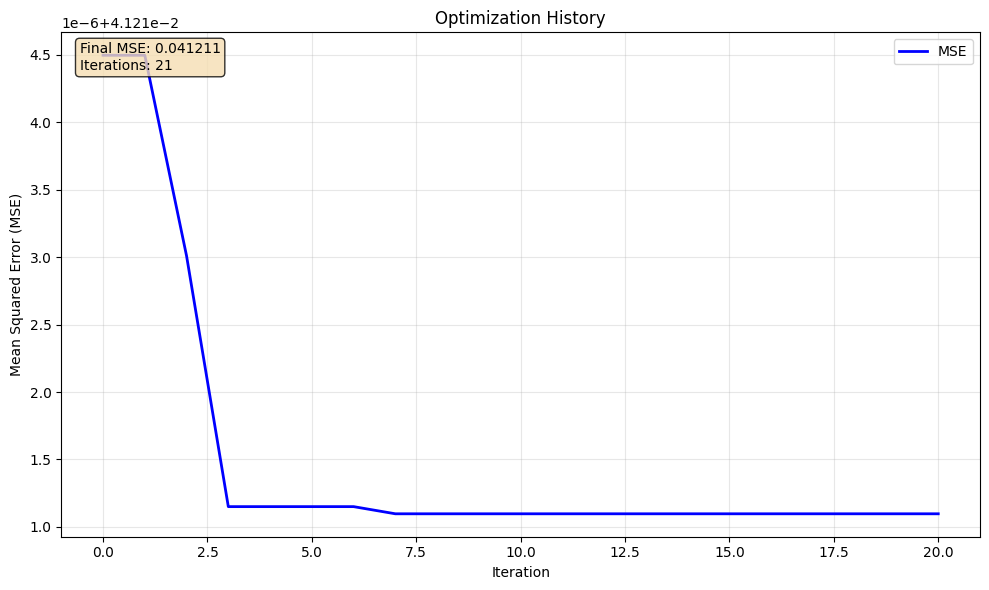

In [10]:
optimizer.plot_optimization_history(result)

In [11]:
print(optimizer.get_pbn_rules_string())

N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 0.6207
N3 = N1 & !N2, 0.3793


In [12]:
# Get optimized PBN
optimized_pbn = optimizer.get_optimized_pbn(result)

# Get steady state
calc = BNMPy.SteadyStateCalculator(optimized_pbn)
steady_state = calc.compute_steady_state(method='monte_carlo',n_runs=10,n_steps=5000,p_noise=0.05,seed=99)
steady_state

array([0.49088365, 0.51331467, 0.40295882])

## Particle Swarm Optimization

In [15]:
# Configure optimizer
config = {
    'seed': 99,
    'max_try': 1,  # Maximum number of attempts if optimization fails
    'success_threshold': 2e-4,
    'pso_params': {
        'n_particles': 30,
        'iters': 100,
        'options': {'c1': 0.5, 'c2': 0.3, 'w': 0.9},
        'ftol': -1,  # Function tolerance for early stopping, -1 for disable
        'ftol_iter': 10  # Number of iterations to check for stagnation
    },
    'steady_state': {
        'method': 'monte_carlo',
        'monte_carlo_params': {
            'n_runs': 5, 
            'n_steps': 1000,
            'p_noise': 0.05,
            'seed': 99
        },
    },
}

In [16]:
# Initialize optimizer
optimizer = BNMPy.ParameterOptimizer(pbn, 'files/experiments.csv', config=config, nodes_to_optimize=['N3'], verbose=False)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-10-30 15:05:49,733 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/1
Running PSO optimization...




pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0412
2025-10-30 15:07:41,203 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.04121109743254676, best pos: [0.4939754  0.30170058]



--- Optimization finished. Best MSE found: 0.041211 ---

--- Optimized PBN Rules ---
N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 0.6208
N3 = N1 & !N2, 0.3792
---------------------------



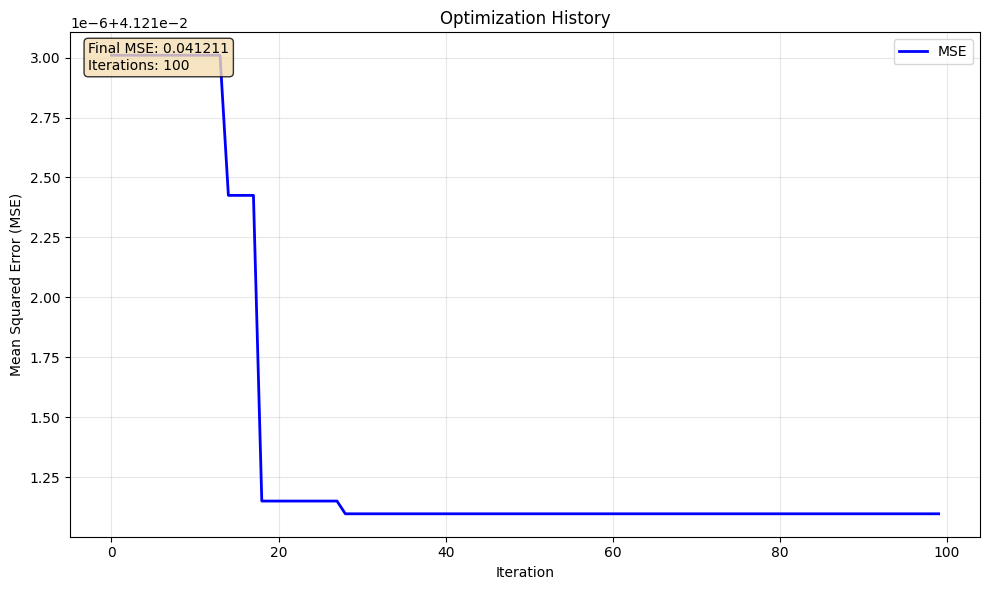

In [17]:
optimizer.plot_optimization_history(result)

## Discrete Mode Optimization

Now let's try optimizing for a Boolean Network (discrete mode).
  
Synthetic experimental data obtained from this network:  
  
N1 = N1, 1  
N2 = N2, 1  
N3 = N1, 0.9  
N3 = N1 & !N2, 0.1  

In [18]:
experiments_discrete = pd.DataFrame({
    'Experiments': [1, 2, 3],
    'Stimuli': ['', 'N1,N2', 'N1'],
    'Inhibitors': ['', '', 'N2'],
    'Measured_nodes': ['N3', 'N3', 'N3'],
    'Measured_values': ['0.475', '0.9', '1']
})
experiments_discrete.to_csv('files/experiments_discrete.csv', index=False)

In [ ]:
# Initialize optimizer with discrete config
discrete_config = config.copy()
discrete_config['discrete_params'] = {'threshold': 0.6}
discrete_optimizer = BNMPy.meterOptimizer(pbn, 'files/experiments_discrete.csv', config=discrete_config, nodes_to_optimize=['N3'], discrete=True)

# Run optimization in discrete mode using DE
discrete_result = discrete_optimizer.optimize(
    method='differential_evolution'
)


Running optimization using method: differential_evolution
Maximum attempts: 3

--- Attempt 1/3 ---
[░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 0.2% | Iter: 1/500 | Best SSE: 0.006017 | Conv: 0.0118

Successful optimization found in attempt 1
  - SSE: 0.002719

--- Optimization finished. Best SSE found: 0.002719 ---

Discretizing final parameters...

Discretized Selection Probabilities:
[[ 1. -1.]
 [ 1. -1.]
 [ 1.  0.]]

--- Optimized PBN Rules ---
N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 1.0000
---------------------------



In [12]:
print(optimizer.get_pbn_rules_string())

N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 1.0000


## Formula-based measurements

Two ways to optimize against a formula (e.g., `N1 + N2 - N3`):

- Use a global formula override via `Measured_formula` in the optimizer
- Parse formulas from CSV by setting `use_formula=True` when loading experiments


In [ ]:
# Example 1: Parse formula directly from CSV with use_formula=True
# The CSV column Measured_nodes should contain the formula string, and Measured_values must have a single value per row

# Create experimental data
# This is generated by the following network:
# N1 = N1, 1
# N2 = N2, 1
# N3 = N1, 0.1
# N3 = N1 & !N2, 0.9
experiments = pd.DataFrame({
    'Experiments': [1, 2, 3],
    'Stimuli': ['', 'N1,N2', 'N1'],
    'Inhibitors': ['', '', 'N2'],
    'Measured_nodes': ['N1 + N2 + N3', 'N1 + N2 + N3', 'N1 + N2 + N3'],
    'Measured_values': ['1.14', '2.14', '1.95']
})
experiments.to_csv('files/experiments_formula.csv', index=False)

In [3]:
# load experiments
experiments_formula = BNMPy.ExperimentData.load_from_csv('files/experiments_formula.csv', use_formula=True)

# config
config = {
    'seed': 99,
    'max_try': 1,  # Maximum number of attempts if optimization fails
    'success_threshold': 2e-4,
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 50,
        'popsize': 20,
        'tol': 0.00001,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1, # Use all available cores for parallelization
        'polish': False,  # Disable polish step for faster runs
    },
    'steady_state': {
        'method': 'monte_carlo',
        'monte_carlo_params': {
            'n_runs': 5, 
            'n_steps': 1000,
            'p_noise': 0.05,
            'seed': 99
        },
    },
}

# optimize
optimizer_formula = BNMPy.ParameterOptimizer(
    pbn,
    experiments_formula,
    config=config,
    nodes_to_optimize=['N3'],
    verbose=False
)
result_formula = optimizer_formula.optimize(method='differential_evolution')


Optimization attempt 1/1
Running DE optimization...


[█████████░░░░░░░░░░░░░░░░░░░░░] 32.0% | Iter: 16/50 | Best MSE: 0.394369 | Conv: 4.6525

--- Optimization finished. Best MSE found: 0.394369 ---

--- Optimized PBN Rules ---
N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 0.0989
N3 = N1 & !N2, 0.9011
---------------------------



In [4]:
# Example 2: Use a global formula directly
# Optimizes against the score N1 + N2 + N3 using the CSV's Measured_values (one value per row)
optimizer_formula = BNMPy.ParameterOptimizer(
    pbn,
    'files/experiments_formula.csv',
    config=config,
    nodes_to_optimize=['N3'],
    verbose=False,
    Measured_formula='N1 + N2 + N3' # using the formula directly
)
result_formula = optimizer_formula.optimize(method='differential_evolution')


Optimization attempt 1/1
Running DE optimization...


[█████████░░░░░░░░░░░░░░░░░░░░░] 32.0% | Iter: 16/50 | Best MSE: 0.394369 | Conv: 4.6525

--- Optimization finished. Best MSE found: 0.394369 ---

--- Optimized PBN Rules ---
N1 = N1, 1.0000
N2 = N2, 1.0000
N3 = N1, 0.0989
N3 = N1 & !N2, 0.9011
---------------------------

